In [1]:
#hide
# !pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [2]:
#hide
from fastbook import *
from fastai.vision.widgets import *

# Image search

In [3]:
import os
key = os.environ.get('AZURE_SEARCH_KEY', 'redacted')

In [4]:
results = search_images_bing(key, 'adenium succulent')
ims = results.attrgot('contentUrl')
len(ims)

150

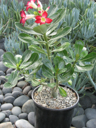

In [5]:
dest = 'images/succulent_test.jpg'
download_url(ims[0], dest)
im = Image.open(dest)
im.to_thumb(128,128)

In [8]:
succulent_types = [
    'adenium',
    'adromischus',
    'aeonium',
    'agave',
    'aloe',
    'ceropegia',
    'crassula',
    'echeveria',
    'euphorbia',
    'gasteria',
    'graptopetalum',
    'haworthia',
    'ice_plant',
    'kalanchoe',
    'lithops',
    'sansevieria',
    'schlumbergera',
    'sedum',
    'sempervivum',
    'senecio'
]
path = Path('succulents')

In [9]:
from urllib.parse import urljoin, urlparse

if not path.exists():
    path.mkdir()
    for o in succulent_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        search_term = o.replace('_', ' ') + ' succulent'
        results = search_images_bing(key, search_term)
        urls = results.attrgot('contentUrl')
        urls_no_qs = [urljoin(item, urlparse(item).path) for item in urls]
        download_images(dest, urls=urls_no_qs)

In [10]:
fns = get_image_files(path)
fns

(#2968) [Path('succulents/ceropegia/00000054.jpg'),Path('succulents/ceropegia/00000139.jpg'),Path('succulents/ceropegia/00000120.jpg'),Path('succulents/ceropegia/00000141.jpg'),Path('succulents/ceropegia/00000023.jpg'),Path('succulents/ceropegia/00000016.jpg'),Path('succulents/ceropegia/00000138.jpg'),Path('succulents/ceropegia/00000010.jpg'),Path('succulents/ceropegia/00000004.jpg'),Path('succulents/ceropegia/00000125.jpg')...]

In [11]:
failed = verify_images(fns)
failed

/home/ubuntu/miniconda3/lib/python3.8/site-packages/PIL/Image.py:2966: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)
/home/ubuntu/miniconda3/lib/python3.8/site-packages/PIL/Image.py:2966: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)
/home/ubuntu/miniconda3/lib/python3.8/site-packages/PIL/Image.py:2966: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)
/home/ubuntu/miniconda3/lib/python3.8/site-packages/PIL/Image.py:2966: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


(#98) [Path('succulents/ceropegia/00000120.jpg'),Path('succulents/ceropegia/00000010.jpg'),Path('succulents/ceropegia/00000125.jpg'),Path('succulents/ceropegia/00000080.jpg'),Path('succulents/ceropegia/00000088.jpg'),Path('succulents/agave/00000060.jpg'),Path('succulents/senecio/00000022.jpg'),Path('succulents/senecio/00000061.jpg'),Path('succulents/senecio/00000059.jpg'),Path('succulents/senecio/00000042.png')...]

In [16]:
failed.map(Path.unlink);

# Data loading and training

## Set up data loaders

In [17]:
succulents = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [18]:
dls = succulents.dataloaders(path)

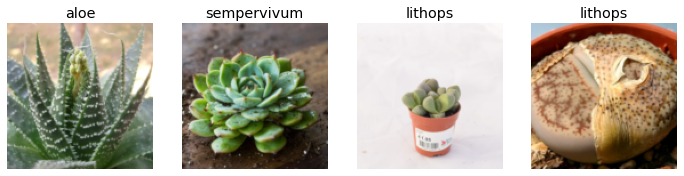

In [19]:
dls.valid.show_batch(max_n=4, nrows=1)

In [21]:
succulents = succulents.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = succulents.dataloaders(path)

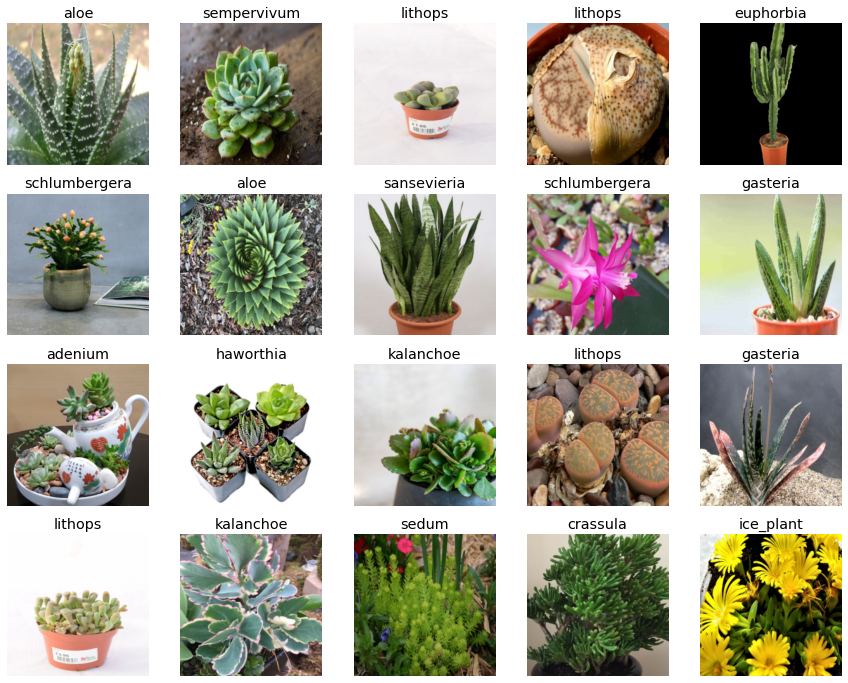

In [22]:
dls.valid.show_batch(max_n=20, nrows=4)

## Initial training and cleaning

In [23]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(2)

/home/ubuntu/miniconda3/lib/python3.8/site-packages/PIL/Image.py:962: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/ubuntu/miniconda3/lib/python3.8/site-packages/PIL/Image.py:962: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


/home/ubuntu/miniconda3/lib/python3.8/site-packages/PIL/Image.py:962: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/ubuntu/miniconda3/lib/python3.8/site-packages/PIL/Image.py:962: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/ubuntu/miniconda3/lib/python3.8/site-packages/PIL/Image.py:962: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/ubuntu/miniconda3/lib/python3.8/site-packages/PIL/Image.py:962: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/ubuntu/miniconda3/lib/python3.8/site-packages/PIL/Image.py:962: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


/home/ubuntu/miniconda3/lib/python3.8/site-packages/PIL/Image.py:962: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


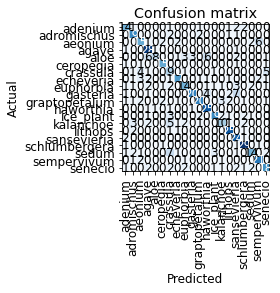

In [24]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

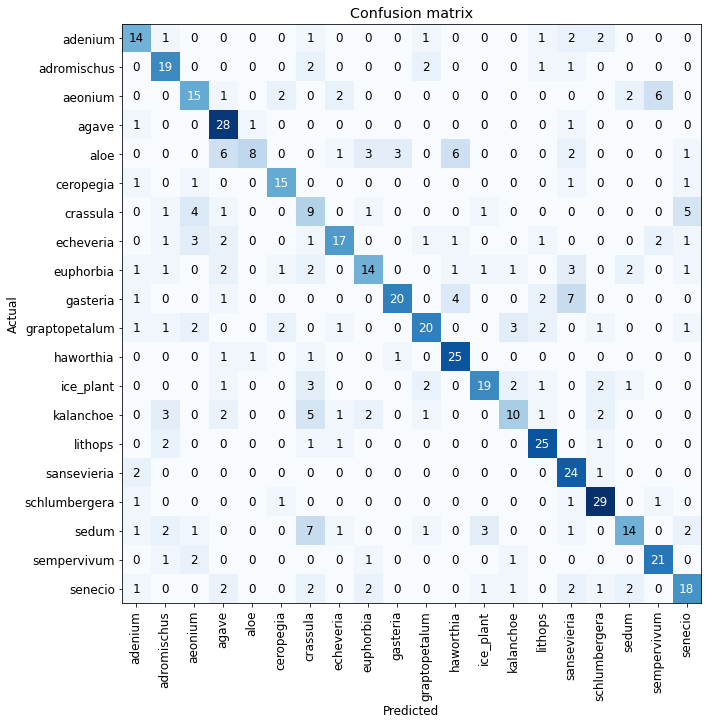

In [29]:
interp.plot_confusion_matrix(figsize=(10,10))

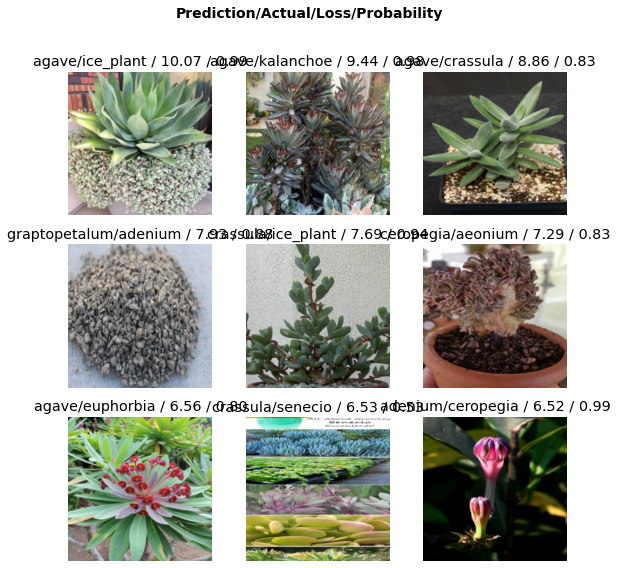

In [31]:
interp.plot_top_losses(9, nrows=3)

In [32]:
cleaner = ImageClassifierCleaner(learn)
cleaner

/home/ubuntu/miniconda3/lib/python3.8/site-packages/PIL/Image.py:962: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/ubuntu/miniconda3/lib/python3.8/site-packages/PIL/Image.py:962: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


/home/ubuntu/miniconda3/lib/python3.8/site-packages/PIL/Image.py:962: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


FileNotFoundError: [Errno 2] No such file or directory: '/home/ubuntu/src/bonnici-fastbook/clean/succulents/adenium/00000107.jpg'

In [44]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
# for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

## Full training

In [46]:
succulents = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [47]:
succulents = succulents.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = succulents.dataloaders(path)

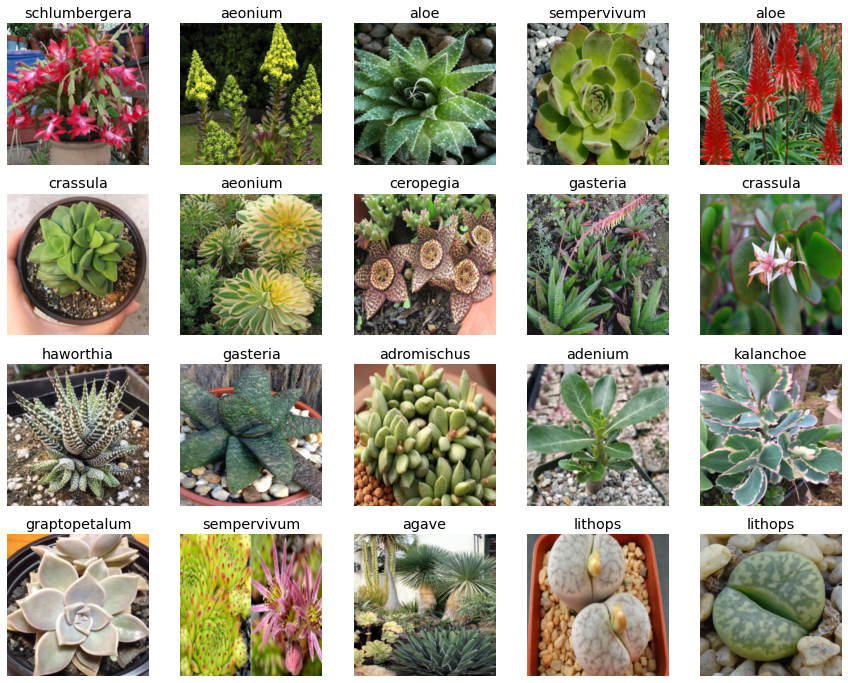

In [48]:
dls.valid.show_batch(max_n=20, nrows=4)

In [54]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(8)

/home/ubuntu/miniconda3/lib/python3.8/site-packages/PIL/Image.py:962: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/ubuntu/miniconda3/lib/python3.8/site-packages/PIL/Image.py:962: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/ubuntu/miniconda3/lib/python3.8/site-packages/PIL/Image.py:962: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


/home/ubuntu/miniconda3/lib/python3.8/site-packages/PIL/Image.py:962: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/ubuntu/miniconda3/lib/python3.8/site-packages/PIL/Image.py:962: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/ubuntu/miniconda3/lib/python3.8/site-packages/PIL/Image.py:962: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/ubuntu/miniconda3/lib/python3.8/site-packages/PIL/Image.py:962: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/ubuntu/miniconda3/lib/python3.8/site-packages/PIL/Image.py:962: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/ubuntu/miniconda3/lib/python3.8/site-packages/PIL/Image.py:

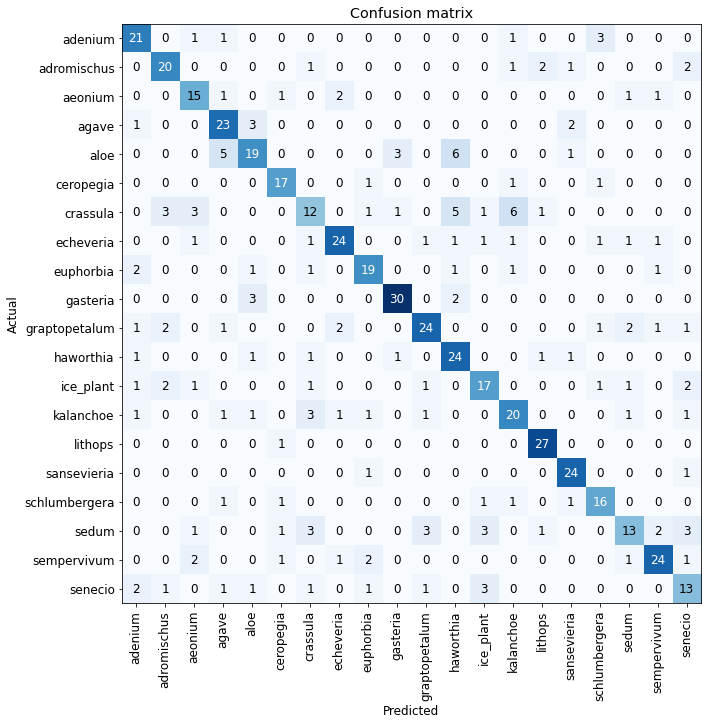

In [55]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(10,10))

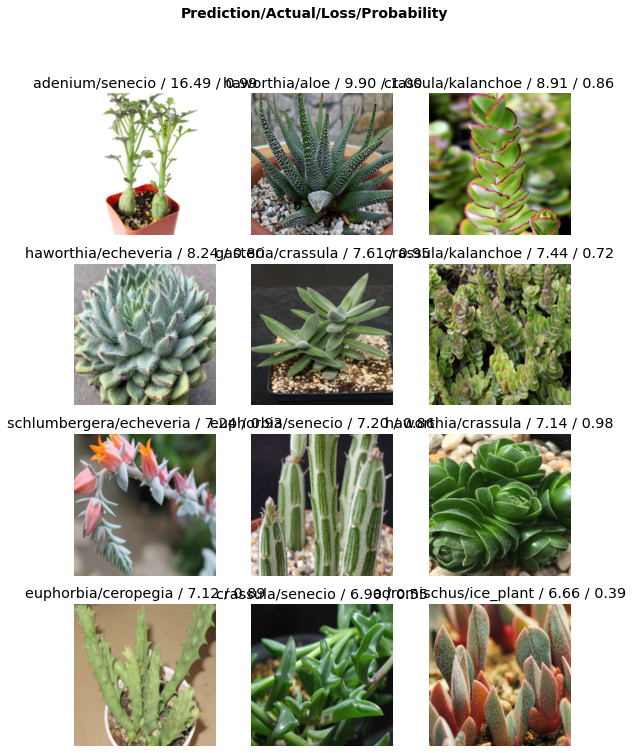

In [56]:
interp.plot_top_losses(12, nrows=4)

# Production

## Export model

In [59]:
learn.export(fname='succulent_v1_export.pkl')

In [60]:
path = Path()
path.ls(file_exts='.pkl')

(#2) [Path('succulent_v1_export.pkl'),Path('export.pkl')]

In [61]:
learn_inf = load_learner(path/'succulent_v1_export.pkl')

In [62]:
learn_inf.predict('images/succulent_test.jpg')

('adenium',
 tensor(0),
 tensor([9.8603e-01, 4.9379e-07, 5.5630e-07, 1.4344e-04, 5.5837e-06, 2.6589e-06, 1.8043e-05, 1.0955e-05, 2.1848e-04, 1.2022e-05, 2.1741e-05, 2.6056e-05, 5.5328e-06, 7.7195e-05, 4.3694e-07, 1.3321e-02,
         5.6412e-05, 2.0234e-06, 2.3961e-06, 4.9439e-05]))

In [63]:
learn_inf.dls.vocab

['adenium', 'adromischus', 'aeonium', 'agave', 'aloe', 'ceropegia', 'crassula', 'echeveria', 'euphorbia', 'gasteria', 'graptopetalum', 'haworthia', 'ice_plant', 'kalanchoe', 'lithops', 'sansevieria', 'schlumbergera', 'sedum', 'sempervivum', 'senecio']

## Getting widgets ready

In [64]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [65]:
img = PILImage.create(btn_upload.data[-1])

In [66]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [67]:
pred,pred_idx,probs = learn_inf.predict(img)

In [69]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: echeveria; Probability: 0.968400')

In [70]:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [87]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'{pred}! Probability: {probs[pred_idx] * 100:.02f}%'

btn_run.on_click(on_click_classify)

In [88]:
VBox([widgets.Label('Select your succulent!'), 
      btn_upload, btn_run, out_pl, lbl_pred])

## Turning it into an app

In [89]:
!pip install voila
!jupyter serverextension enable --sys-prefix voila 

Enabling: voila
- Writing config: /home/ubuntu/miniconda3/etc/jupyter
    - Validating...
      voila 0.2.10 OK


## Created standalone notebook: 02_production_app.ipynb